### Load the trainer

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys

sam3_root = "/home/kalyanv/sam3"
sys.path.append(f"{sam3_root}/examples")

from utils import draw_box_on_image, show_img_tensor, show_points_with_labels, plot_bbox, plot_mask, COLORS

def plot_results(img, results):
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    nb_objects = len(results["scores"])
    print(f"found {nb_objects} object(s)")
    for i in range(nb_objects):
        color = COLORS[i % len(COLORS)]
        plot_mask(results["masks"][i].squeeze(0).cpu(), color=color)
        w, h = img.size
        prob = results["scores"][i].item()
        plot_bbox(
                h,
                w,
                results["boxes"][i].cpu(),
                text=f"(id={i}, {prob=:.2f})",
                box_format="XYXY",
                color=color,
                relative_coords=False,
            )


Bad key keymap.all_axes in file /tmp/par_unpack.bento_cloud.168753.096461d0d1e948435d488359ec35137d/bento/server/matplotlibrc-3.1.3, line 76 ('keymap.all_axes : a                 # enable all axes')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.6/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


Converting 5000 RGB samples to LAB color space...
Conversion to LAB complete.
Fitting KMeans with 128 clusters on 5000 samples...


KMeans fitting complete.


In [2]:
import torch
# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# Build Model

In [3]:
from sam3 import build_sam3_image_model

bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"
checkpoint_path = f"{sam3_root}/assets/checkpoints/paper_ckpt_model_only_from_fair_sc.pt"
model = build_sam3_image_model(bpe_path=bpe_path, checkpoint_path=checkpoint_path)

/storage/home/kalyanv/miniconda/envs/sam3/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
from sam3.model.sam3_image_processor import Sam3Processor

image_path = f"{sam3_root}/assets/images/test_image.jpg"
image = Image.open(image_path)
width, height = image.size
processor = Sam3Processor(model, confidence_threshold=0.5)
inference_state = processor.set_image(image)

# Visual prompt (Box)

In [5]:
def normalize_bbox(raw_box, width, height):
    # Convert point in top-left corner, w, h format to box center, w, h in normalized co-ordinates
    return [(raw_box[0]+  raw_box[2]/2)/width, (raw_box[1] + raw_box[3]/2) /height, raw_box[2]/width, raw_box[3]/height]

Normalized box: [[0.375      0.40277778 0.0859375  0.5       ]]


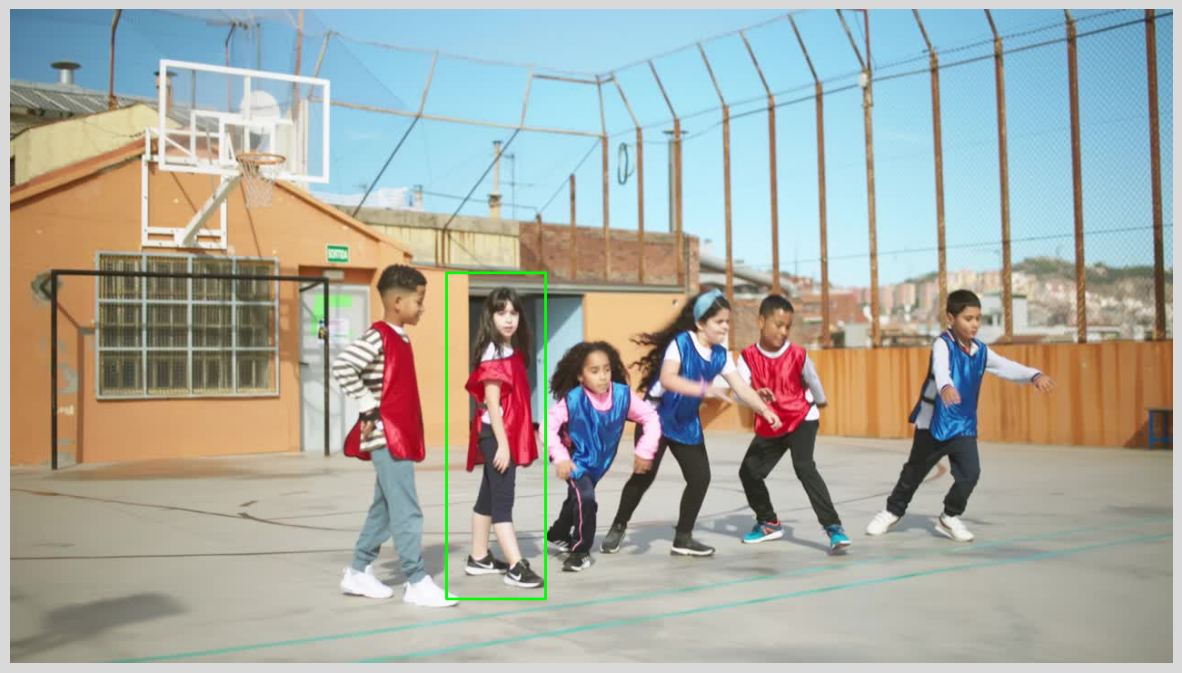

In [15]:
box_input_xywh = [480.0, 290.0, 110.0 , 360.0] # Here the point is in top-left corner, w, h format.


norm_box_xywh = box_input_xywh / np.array([width, height, width, height], dtype=np.float32).reshape(1,-1)
print("Normalized box:", norm_box_xywh)

inference_state = processor.reset_all_prompts(inference_state)
inference_state = processor.add_geometric_prompt(state=inference_state, box=normalize_bbox(box_input_xywh, width, height), label=True)

img0 = Image.open(image_path)
image_with_box = draw_box_on_image(img0, box_input_xywh )
plt.imshow(image_with_box)
plt.axis('off')  # Hide the axis
plt.show()

findfont: Font family 'Noto Sans UI' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Noto Sans TC' not found.
findfont: Font family 'Noto Sans SC' not found.
findfont: Font family 'Noto Sans Thai' not found.
findfont: Font family 'Noto Naskh Arabic UI' not found.
findfont: Font family 'Noto Sans UI' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Noto Sans TC' not found.
findfont: Font family 'Noto Sans SC' not found.
findfont: Font family 'Noto Sans Thai' not found.
findfont: Font family 'Noto Naskh Arabic UI' not found.
findfont: Font family 'Noto Sans UI' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Noto Sans TC' not found.
findfont: Font family 'Noto Sans SC' not found.
findfont: Font family 'Noto Sans Thai' not found.
findfont: Font family 'Noto Naskh Arabic UI' not found.
findfont: Font family 'Noto Sans UI' not found.
findfont: Font family 'Liberation Sans' not found

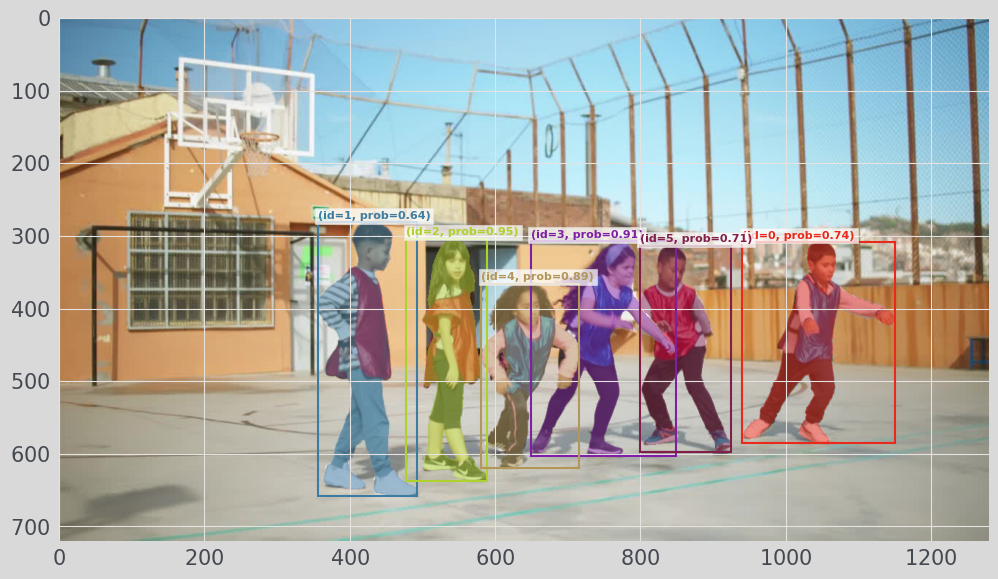

In [16]:
plot_results(img0, inference_state)

# Multi-box prompting (with positive and negative boxes)

Normalized box: [[0.375      0.40277778 0.0859375  0.5       ]]


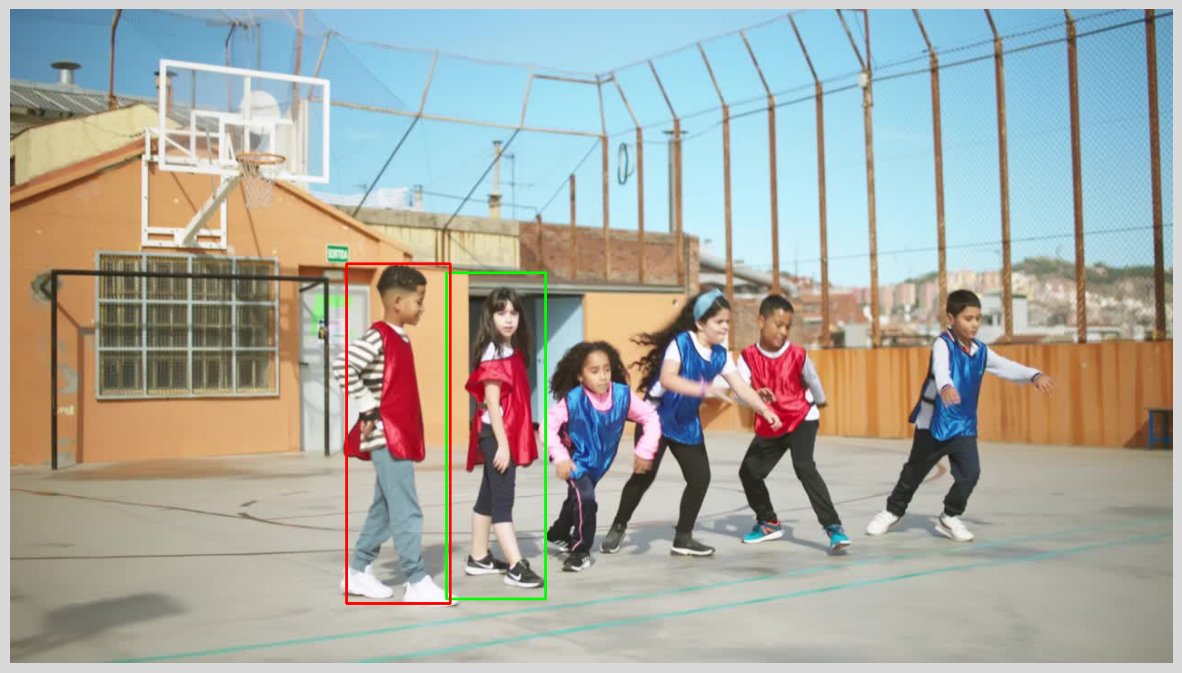

In [8]:
box_input_xywh = [[480.0, 290.0, 110.0 , 360.0],[370.0, 280.0, 115.0 , 375.0]]
box_labels = [True, False]

print("Normalized box:", norm_box_xywh)
processor.reset_all_prompts(inference_state)

for box, label in zip(box_input_xywh, box_labels):
    inference_state = processor.add_geometric_prompt(state=inference_state, box=normalize_bbox(box, width, height), label=label)

img0 = Image.open(image_path)
image_with_box = img0
for i in range(len(box_input_xywh)):
    if box_labels[i] == 1:
        color = (0,255,0)
    else:
        color = (255,0,0)
    image_with_box = draw_box_on_image(image_with_box, box_input_xywh[i],color )
plt.imshow(image_with_box)
plt.axis('off')  # Hide the axis
plt.show()

findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Noto Sans TC' not found.
findfont: Font family 'Noto Sans SC' not found.
findfont: Font family 'Noto Sans Thai' not found.
findfont: Font family 'Noto Naskh Arabic UI' not found.
findfont: Font family 'Noto Sans UI' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Noto Sans TC' not found.
findfont: Font family 'Noto Sans SC' not found.
findfont: Font family 'Noto Sans Thai' not found.
findfont: Font family 'Noto Naskh Arabic UI' not found.
findfont: Font family 'Noto Sans UI' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Noto Sans TC' not found.
findfont: Font family 'Noto Sans SC' not found.
findfont: Font family 'Noto Sans Thai' not found.
findfont: Font family 'Noto Naskh Arabic UI' not found.
findfont: Font family 'Noto Sans UI' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Noto Sans TC' not found

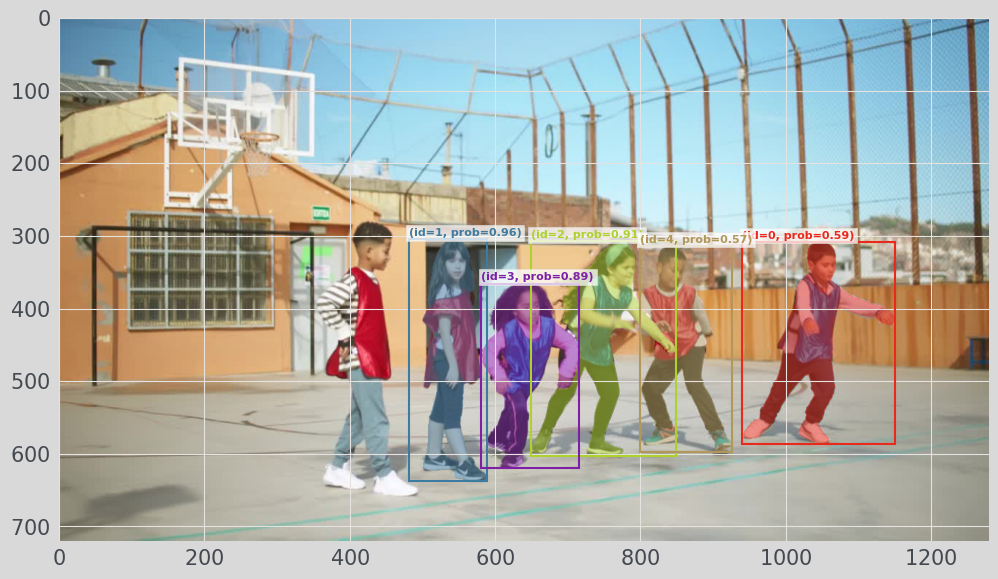

In [9]:
plot_results(img0, inference_state)

# Text prompt

found 12 object(s)


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


findfont: Font family 'Liberation Sans' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans Thai' not found.


findfont: Font family 'Noto Naskh Arabic UI' not found.


findfont: Font family 'Noto Sans UI' not found.


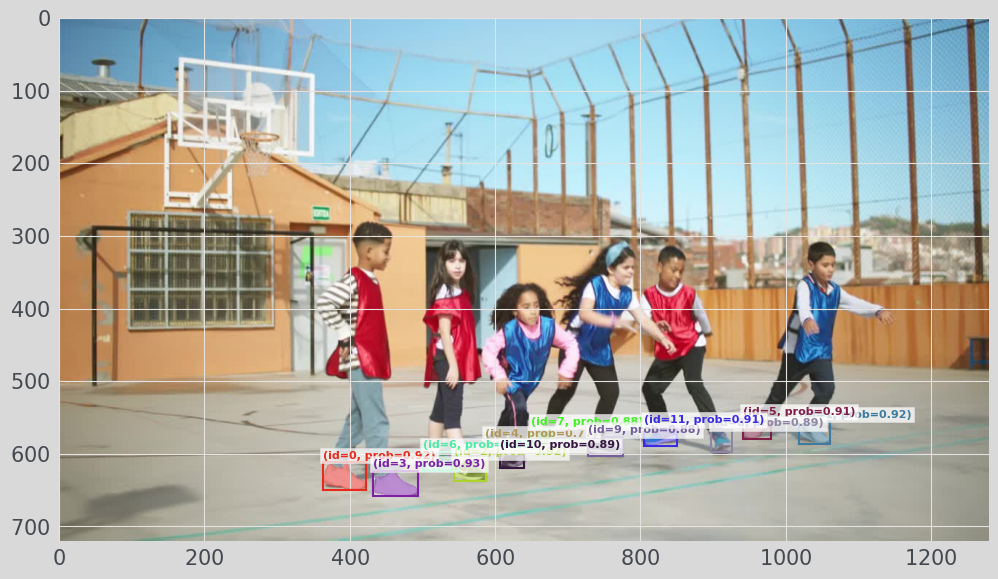

In [10]:
inference_state = processor.reset_all_prompts(inference_state)
inference_state= processor.set_text_prompt(state =inference_state, prompt="shoe")


img0 = Image.open(image_path)
plot_results(img0, inference_state)
